In [195]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
from model import BuildingSimulation as bs, BuildingGraph as bg
from model.utils import *
import matplotlib.colors as mcolors
import seaborn as sns
import networkx as nx


plt.close('all')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [165]:
wallMaterial = {
    "key": "Material",
    "Name": "Concrete Wall",
    "Thickness": 0.1,
    "Conductivity": 0.8,
    "Density": 2300,
    "Specific_Heat": 750,
    "Thermal_Resistance": np.nan
}
wallMaterial = pd.DataFrame(wallMaterial, index = [0]).set_index('Name')

roofMaterial = {
    "key": "Material",
    "Name": "Concerte Roof",
    "Thickness": 0.25,
    "Conductivity": 0.8,
    "Density": 2300,
    "Specific_Heat": 750,
    "Thermal_Resistance": np.nan
}
roofMaterial = pd.DataFrame(roofMaterial, index = [0]).set_index('Name')

floorMaterial = {
    "key": "Material",
    "Name": "Concerte Floor",
    "Thickness": 0.5,
    "Conductivity": 0.8,
    "Density": 2300,
    "Specific_Heat": 750,
    "Thermal_Resistance": np.nan
}
floorMaterial = pd.DataFrame(floorMaterial, index = [0]).set_index('Name')

## Load P4 Data

Text(0.5, 1.0, 'Outdoor temperature')

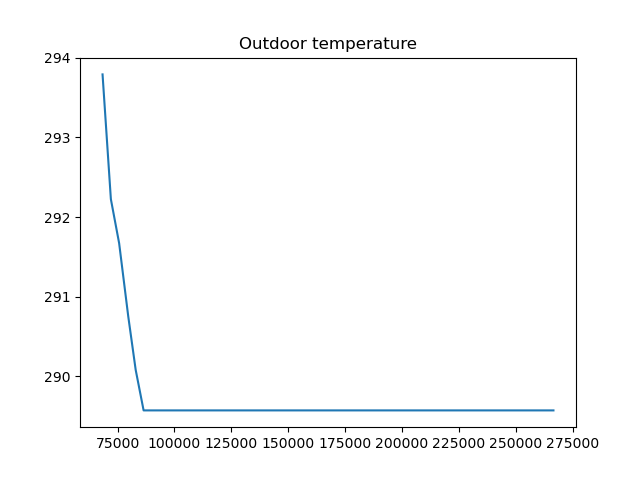

In [166]:
# Window dimmensions
H = 1
W = 1

# Load data
JW = sp.io.loadmat('JulyWeek.mat')
alphas = [42, 42, 42]
As = [1.61, 1.755, 1.755]
Ls = [11.34, 6.62, 2.07]

Q4 = sp.io.loadmat('./Q4data.mat')

Real_Tint = Q4['TintMeas'].flatten() + 273.15

T_start = Real_Tint[0]

hours = Q4['time'].flatten()
times = hours * 60 * 60
Touts = Q4['Tout'].flatten() + 273.15

N = len(times)
repeatcount = 10 * N

Touts = np.concatenate([Touts, np.tile(Touts[-1], repeatcount)])
dt = times[1] - times[0]
times = np.concatenate([times, times[-1] + np.arange(1, repeatcount + 1) * dt])

plt.figure()
plt.plot(times, Touts)
plt.title('Outdoor temperature')

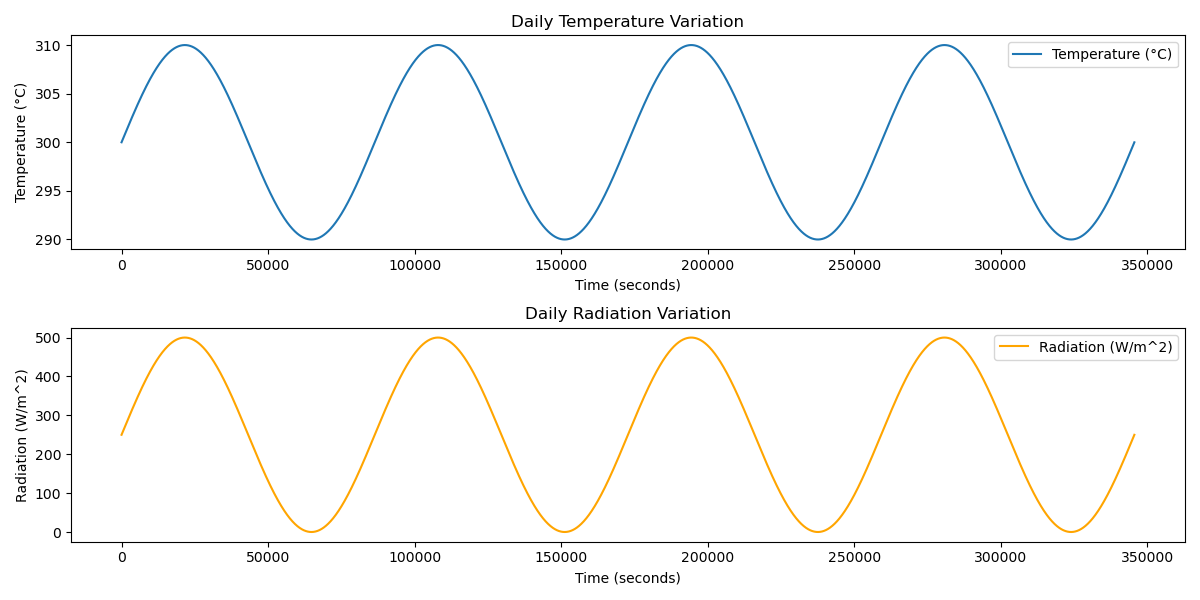

In [207]:
# Function to generate sinusoidal data for temperature and radiation
def generate_sinusoidal_data(delt = 15, amplitude_temp=10, amplitude_radiation=250, length=24):
    length *= 3600  # Converting period from hours to seconds
    period = 24 * 3600
    time = np.arange(0, length, delt)  # Representing a day (24 hours) with a sinusoidal pattern
    temperature = amplitude_temp * np.sin(2 * np.pi * time / period) + 300  # Centered 
    radiation = amplitude_radiation * np.sin(2 * np.pi * time / period) + 250
    return time, temperature, radiation

# Generate sinusoidal data
times, Touts, rad = generate_sinusoidal_data(delt=5, length=96)

# Plotting the data
plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(times, Touts, label='Temperature (°C)')
plt.title('Daily Temperature Variation')
plt.xlabel('Time (seconds)')
plt.ylabel('Temperature (°C)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(times, rad, label='Radiation (W/m^2)', color='orange')
plt.title('Daily Radiation Variation')
plt.xlabel('Time (seconds)')
plt.ylabel('Radiation (W/m^2)')
plt.legend()

plt.tight_layout()
plt.show()

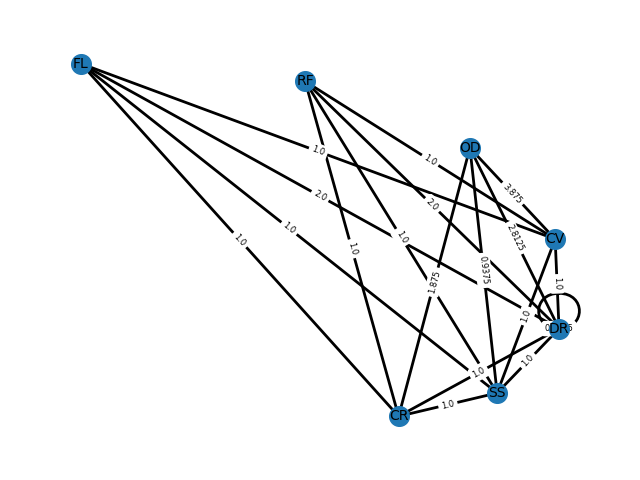

In [168]:
wW = 1- .25**2 #window-wall area
dW = 1 - .25*.75 #door-wall area
interiorRooms = ["CR", "SS", "DR", "CV"]
roomList = [*interiorRooms, "OD", "RF", "FL"]

connectivityMatrix = np.array([
    [0, 1, 1, 0, 2*wW, 1, 1],
    [1, 0, 1 ,1, wW, 1, 1],
    [1, 1, dW, 1, 3*wW, 2, 2],
    [0, 1, 1, 0, 2*wW + 2, 1, 1],
])

bG = bg.BuildingGraph(connectivityMatrix, roomList)
bG.draw()

## Concrete

In [169]:
sim_kwargs = {
    "delt": times[1] - times[0],
    "simLength": times[-1] - times[0],
    "Tout" : Touts,
    "radG": rad,
    "Tfloor": np.mean(Touts),
}
wall_kwargs = {"X": 4, "Y": 3, "material_df": wallMaterial}
wall_kwargs_RF = {"X": 4, "Y": 4, "material_df": roofMaterial}
wall_kwargs_FL = {"X": 4, "Y": 4, "material_df": floorMaterial}

room_kwargs = {
    "T0": Touts[0],
    "V" : 4**2 * 3, #volume of air
    "Eint" : 0 #internal heat generation
}
vent_kwargs = {
    'H': 1,
    'W' : 1,
    "ventType": None,
    "alphas": alphas,
    "As": As,
    "Ls": Ls,
}
rad_kwargs_RF = {
    "bG": bg.BuildingGraph(
        np.array([
            [0, -1, -1, -1, -1],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
        ]),
        ["sun", "SS", "DR", "CV",  "CR", ]
    ),
}

rad_kwargs_FL = {
    "bG": bg.BuildingGraph(
        np.array([
            [0, 3],
            [3, 0],
        ]),
        ["RF", "FL"]
    ),
}



In [170]:
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateEdges({"wall_kwargs" :wall_kwargs_RF}, nodes=["RF"])
bG.updateEdges({"wall_kwargs" :wall_kwargs_FL}, nodes=["FL"])
for e in [("CV", "RF"), ("CV", "FL")]:
    bG.G.edges[e]["wall_kwargs"]["X"] *= 2

bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })
bG.updateNodes({"rad_kwargs": rad_kwargs_RF}, nodes=["RF"])
bG.updateNodes({"rad_kwargs": rad_kwargs_FL}, nodes=["SS", "DR", "CV", "CR"])

for r in ["CR", "DR"]:
    bG.G.nodes[r]["room_kwargs"]["V"] *= 2

build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

maximum time step: 215.625
maximum time step: 215.625
maximum time step: 215.625
maximum time step: 1347.6562500000002
maximum time step: 5390.625000000001
maximum time step: 215.625
maximum time step: 215.625
maximum time step: 215.625
maximum time step: 1347.6562500000002
maximum time step: 5390.625000000001
maximum time step: 215.625
maximum time step: 215.625
maximum time step: 215.625
maximum time step: 1347.6562500000002
maximum time step: 5390.625000000001
maximum time step: 215.625
maximum time step: 1347.6562500000002
maximum time step: 5390.625000000001


<Figure size 640x480 with 0 Axes>

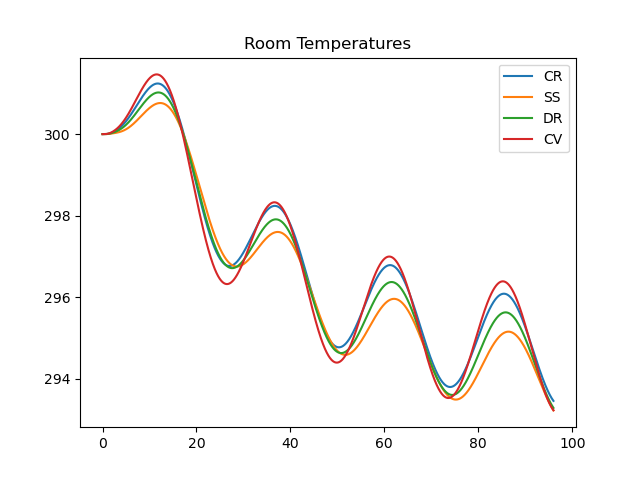

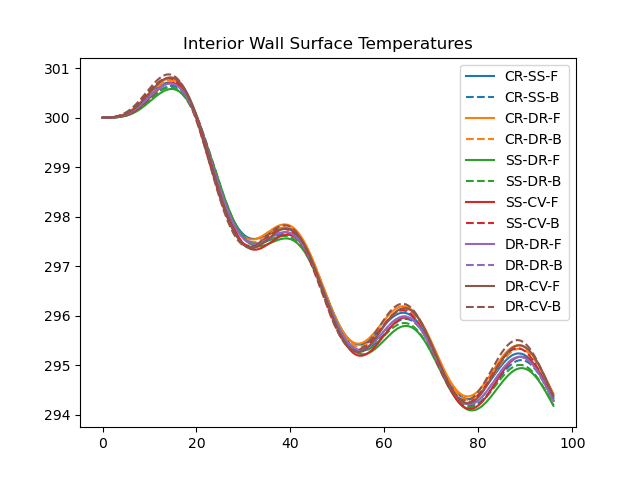

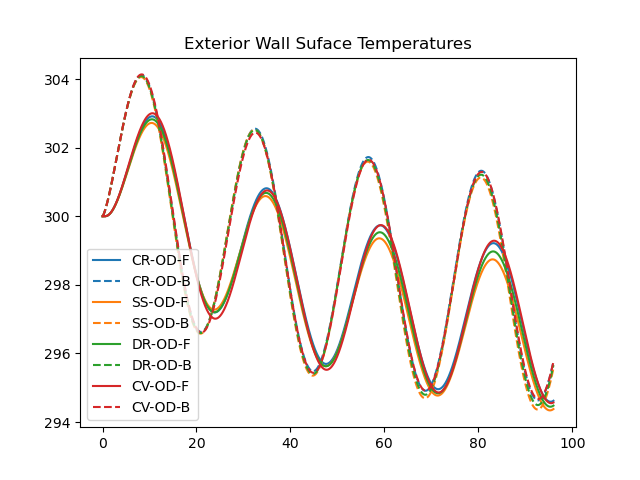

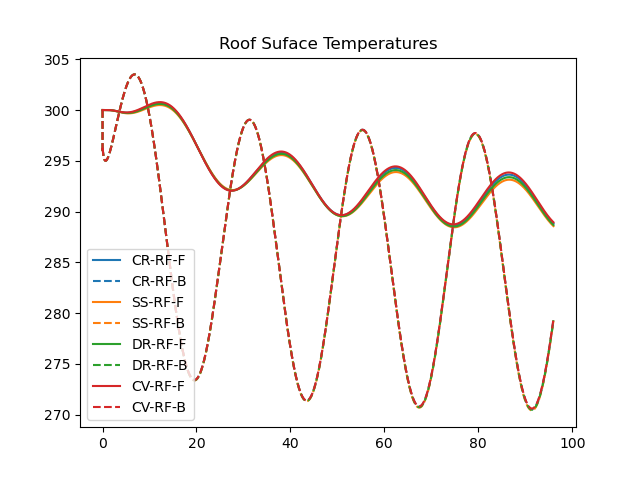

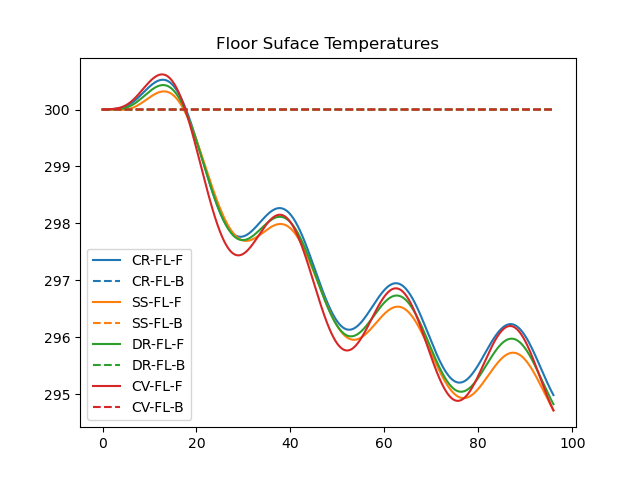

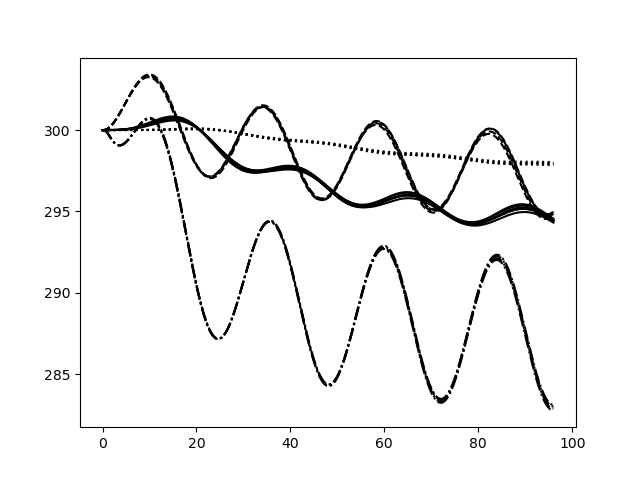

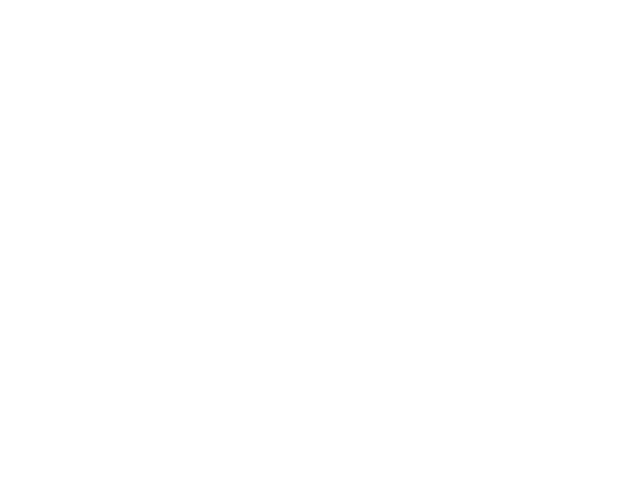

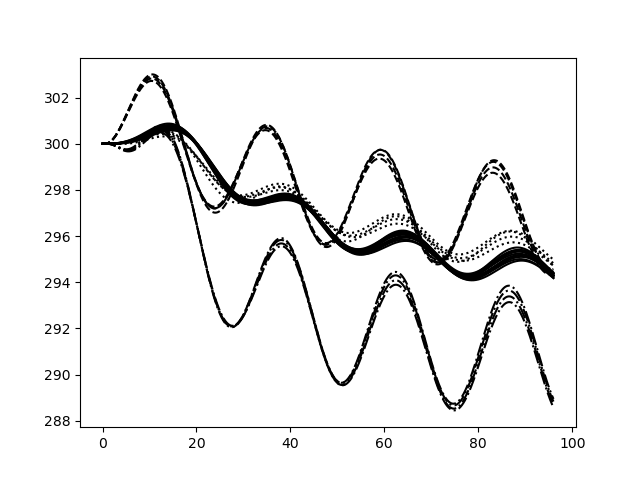

In [171]:
plt.figure()
for n, d in build_sim.bG.G.nodes(data=True):
    if n in interiorRooms:
        plt.plot(build_sim.hours, d['Tints'], label=n)
plt.legend()
plt.title("Room Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        colors = list(mcolors.TABLEAU_COLORS.keys())
        linetypes = ['-', '--']
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Interior Wall Surface Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Exterior Wall Suface Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "RF" or d['nodes'].checkSides(j, False) == "RF":
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Roof Suface Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "FL" or d['nodes'].checkSides(j, False) == "FL":
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Floor Suface Temperatures")

plt.figure()
for i, j, d in build_sim.bG.G.edges(data=True):
    center = int(len(d['T_profs'][:, 0]) / 2)
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        lt = '-'
    elif d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        lt = '--'
    elif d['nodes'].checkSides(i, False) == "RF" or d['nodes'].checkSides(j, False) == "RF":
        lt = '-.'
    elif d['nodes'].checkSides(i, False) == "FL" or d['nodes'].checkSides(j, False) == "FL":
        lt = ':'
    plt.plot(build_sim.hours, d['T_profs'][center, :], color = 'k', linestyle = lt)
    # plt.legend()
plt.figure("Wall Center Temperatures")

plt.figure()
for i, j, d in build_sim.bG.G.edges(data=True):
    center = int(len(d['T_profs'][:, 0]) / 2)
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        lt = '-'
        plt.plot(build_sim.hours, d['T_profs'][-1, :], color = 'k', linestyle = lt)
    elif d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        lt = '--'
    elif d['nodes'].checkSides(i, False) == "RF" or d['nodes'].checkSides(j, False) == "RF":
        lt = '-.'
    elif d['nodes'].checkSides(i, False) == "FL" or d['nodes'].checkSides(j, False) == "FL":
        lt = ':'
    plt.plot(build_sim.hours, d['T_profs'][0, :], color = 'k', linestyle = lt)
    # plt.legend()
plt.figure("Wall Center Temperatures")

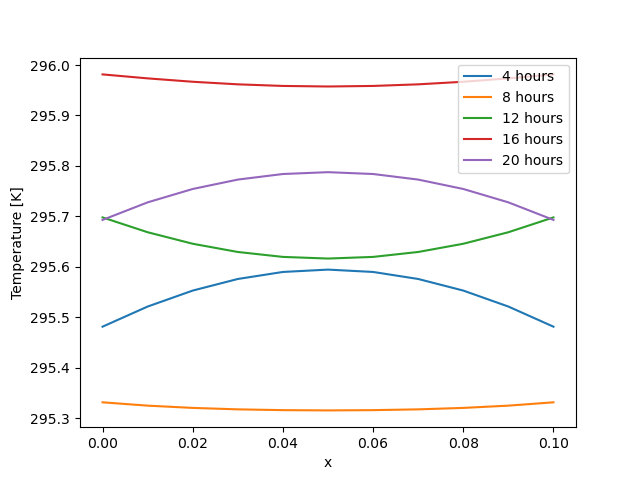

In [172]:
plt.figure()
h_profs = [4, 8, 12, 16, 20]
h_profs = [h + 48 for h in h_profs]
wall = build_sim.bG.G.edges['DR', 'DR']['wall']
T_profs = build_sim.bG.G.edges['DR', 'DR']['T_profs']
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')
plt.show()

Text(0.5, 1.0, 'Interior Wall - Floor; Surface Temperatures')

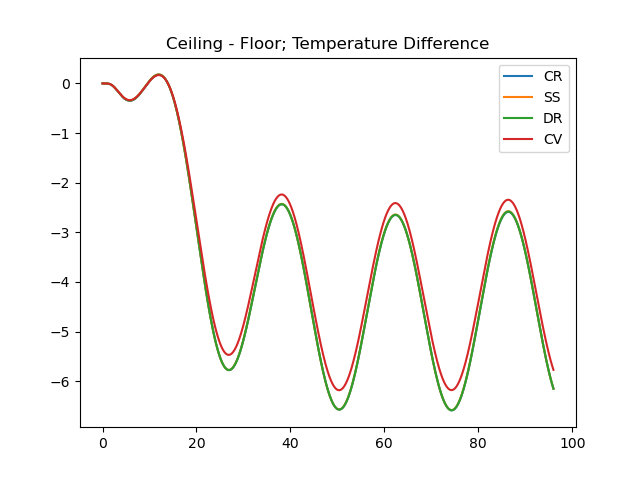

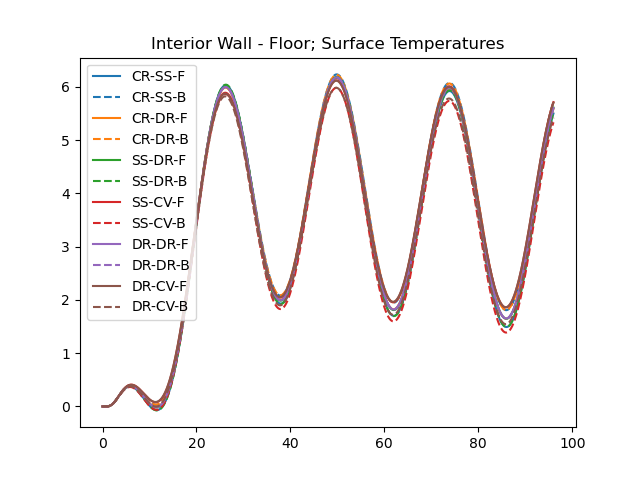

In [173]:
plt.figure()
for n, _ in build_sim.bG.G.nodes(data=True):
    if n in interiorRooms:
        ceiling_temp = build_sim.bG.G[n]["RF"]["T_profs"][0, :]
        floor_temp = build_sim.bG.G[n]["FL"]["T_profs"][0, :]
        plt.plot(build_sim.hours, ceiling_temp - floor_temp, label=n)
plt.legend()
plt.title("Ceiling - Floor; Temperature Difference")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        colors = list(mcolors.TABLEAU_COLORS.keys())
        linetypes = ['-', '--']
        floor_temp = build_sim.bG.G[i]["RF"]["T_profs"][0, :]
        plt.plot(build_sim.hours, d['T_profs'][0, :] - floor_temp, label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        floor_temp = build_sim.bG.G[j]["RF"]["T_profs"][0, :]
        plt.plot(build_sim.hours, d['T_profs'][-1, :] - floor_temp, label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Interior Wall - Floor; Surface Temperatures")

## Medium Wall

In [217]:
constructions  = pd.read_csv("energyPlus/ASHRAE_2005_HOF_Constructions.csv", index_col="Name")
materials = pd.read_csv("energyPlus/ASHRAE_2005_HOF_Materials.csv", index_col="Name")


def cleanMaterial(materialName, reverse = True):
    wallLayers = ["Outside_Layer", "Layer_2", "Layer_3", "Layer_4", "Layer_5"]
    if reverse:
        wallLayers = wallLayers[::-1]
    material_df = []
    for layer in wallLayers:
        material = constructions[layer][materialName]
        if isinstance(material, str):
            conductivity = materials["Conductivity"][material]
            if (conductivity > 10) == False: # filter out the materials with conductivity > 10 that mess up solver and basically transfer all heat
                material_df.append(materials.loc[material])
    return pd.DataFrame(material_df)

wallMaterial = cleanMaterial("Medium Exterior Wall")
partitionMaterial = cleanMaterial("Medium Partitions")
roofMaterial = cleanMaterial("Medium Roof/Ceiling")
floorMaterial = cleanMaterial("Medium Floor")

display(wallMaterial, partitionMaterial, roofMaterial, floorMaterial)

# plt.figure()
# for i, material in enumerate([wallMaterial, partitionMaterial, roofMaterial, floorMaterial]):
#     sns.barplot(x = i, y = material["Deth"], hue = material["Conductivity"])

,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance
G01a 19mm gypsum board,Material,MediumSmooth,0.0190,0.16,800.0,1090.0,NaN
F04 Wall air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.15
I02 50mm insulation board,Material,MediumRough,0.0508,0.03,43.0,1210.0,NaN
M01 100mm brick,Material,MediumRough,0.1016,0.89,1920.0,790.0,NaN


,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance
G01a 19mm gypsum board,Material,MediumSmooth,0.019,0.16,800.0,1090.0,NaN
F04 Wall air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.15
G01a 19mm gypsum board,Material,MediumSmooth,0.019,0.16,800.0,1090.0,NaN


,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance
F16 Acoustic tile,Material,MediumSmooth,0.0191,0.06,368.0,590.0,NaN
F05 Ceiling air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.18
M14a 100mm heavyweight concrete,Material,MediumRough,0.1016,1.95,2240.0,900.0,NaN


,key,Roughness,Thickness,Conductivity,Density,Specific_Heat,Thermal_Resistance
M14a 100mm heavyweight concrete,Material,MediumRough,0.1016,1.95,2240.0,900.0,NaN
F05 Ceiling air space resistance,Material:AirGap,NaN,NaN,NaN,NaN,NaN,0.18
F16 Acoustic tile,Material,MediumSmooth,0.0191,0.06,368.0,590.0,NaN


In [218]:
sim_kwargs = {
    "delt": times[1] - times[0],
    "simLength": times[-1] - times[0],
    "Tout" : Touts,
    "radG": rad,
    "Tfloor": np.mean(Touts),
}
wall_kwargs = {"X": 4, "Y": 3, "material_df": partitionMaterial}
wall_kwargs_OD = {"X": 4, "Y": 3, "material_df": wallMaterial}
wall_kwargs_RF = {"X": 4, "Y": 4, "material_df": roofMaterial}
wall_kwargs_FL = {"X": 4, "Y": 4, "material_df": floorMaterial}

room_kwargs = {
    "T0": Touts[0],
    "V" : 4**2 * 3, #volume of air
    "Eint" : 0 #internal heat generation
}
vent_kwargs = {
    'H': 1,
    'W' : 1,
    "ventType": None,
    "alphas": alphas,
    "As": As,
    "Ls": Ls,
}
rad_kwargs_RF = {
    "bG": bg.BuildingGraph(
        np.array([
            [0, -1, -1, -1, -1],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
            [-1, 0, 0, 0, 0],
        ]),
        ["sun", "SS", "DR", "CV",  "CR", ]
    ),
}

rad_kwargs_FL = {
    "bG": bg.BuildingGraph(
        np.array([
            [0, 3],
            [3, 0],
        ]),
        ["RF", "FL"]
    ),
}



In [219]:
bG.updateEdges({"wall_kwargs" :wall_kwargs})
bG.updateEdges({"wall_kwargs" :wall_kwargs_OD}, nodes=["OD"])
bG.updateEdges({"wall_kwargs" :wall_kwargs_RF}, nodes=["RF"])
bG.updateEdges({"wall_kwargs" :wall_kwargs_FL}, nodes=["FL"])
for e in [("CV", "RF"), ("CV", "FL")]:
    bG.G.edges[e]["wall_kwargs"]["X"] *= 2

bG.updateNodes({
    "room_kwargs": room_kwargs,
    "vent_kwargs": vent_kwargs,
    "rad_kwargs": {"bG": bg.BuildingGraph()},
    })
bG.updateNodes({"rad_kwargs": rad_kwargs_RF}, nodes=["RF"])
bG.updateNodes({"rad_kwargs": rad_kwargs_FL}, nodes=["SS", "DR", "CV", "CR"])

for r in ["CR", "DR"]:
    bG.G.nodes[r]["room_kwargs"]["V"] *= 2

build_sim = bs.BuildingSimulation(**sim_kwargs)
build_sim.initialize(bG)
build_sim.run()

maximum time step: 6.8742
maximum time step: 6.8742
maximum time step: 31.00625999999999
maximum time step: 26.201556
maximum time step: 26.201556
maximum time step: 6.8742
maximum time step: 6.8742
maximum time step: 31.00625999999999
maximum time step: 26.201556
maximum time step: 26.201556
maximum time step: 6.8742
maximum time step: 6.8742
maximum time step: 31.00625999999999
maximum time step: 26.201556
maximum time step: 26.201556
maximum time step: 31.00625999999999
maximum time step: 26.201556
maximum time step: 26.201556


/var/folders/z4/gbjchz2x4hs8f0k6b6t8m5jm0000gn/T/ipykernel_6422/1212940484.py:1: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



<Figure size 1280x960 with 0 Axes>

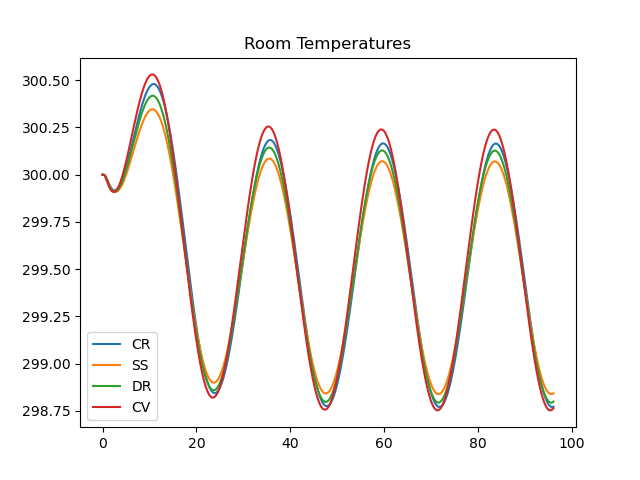

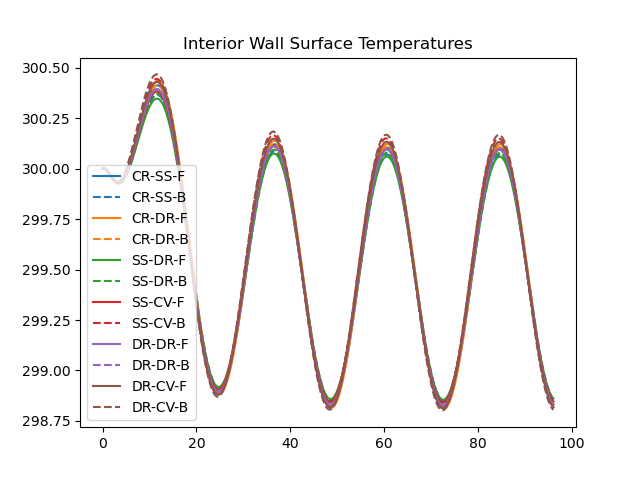

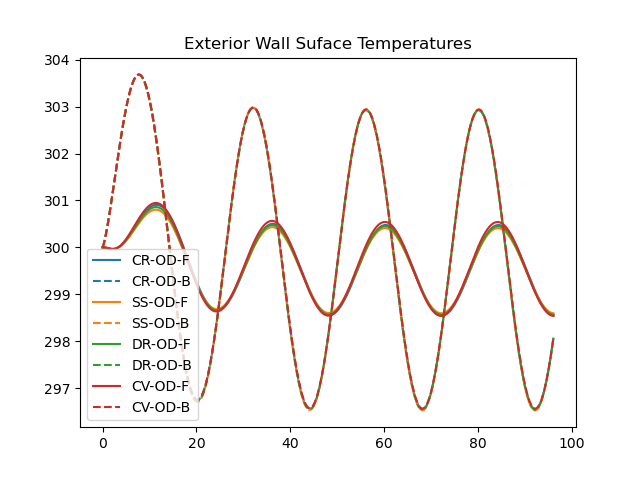

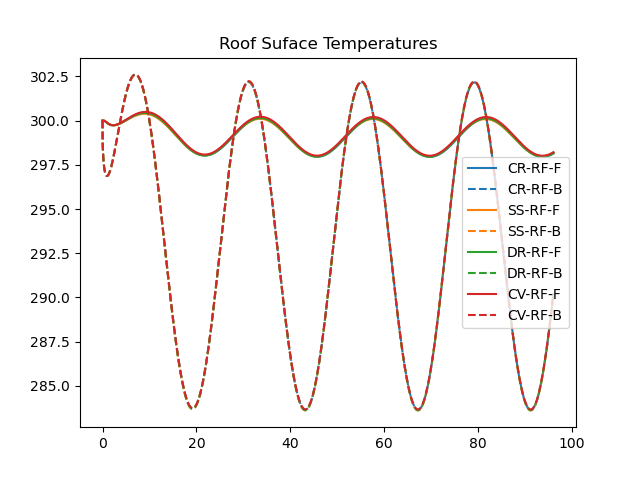

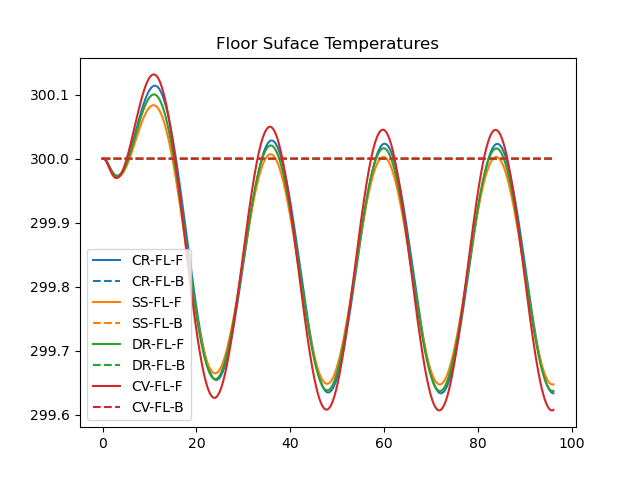

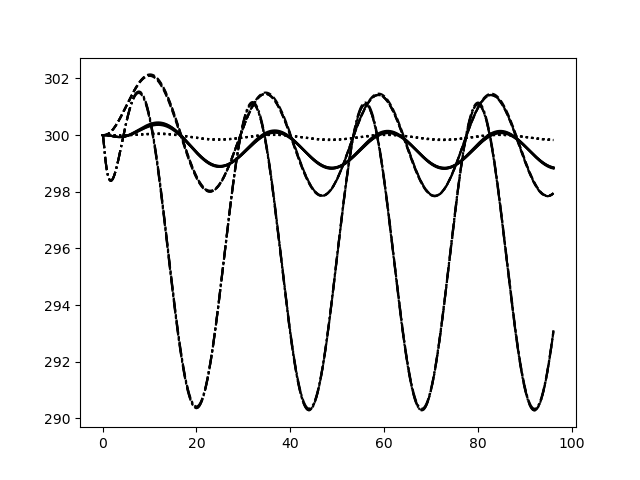

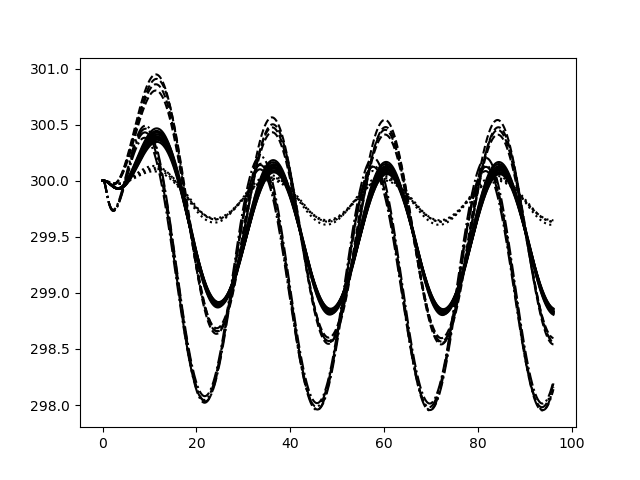

In [220]:
plt.figure()
for n, d in build_sim.bG.G.nodes(data=True):
    if n in interiorRooms:
        plt.plot(build_sim.hours, d['Tints'], label=n)
plt.legend()
plt.title("Room Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        colors = list(mcolors.TABLEAU_COLORS.keys())
        linetypes = ['-', '--']
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Interior Wall Surface Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Exterior Wall Suface Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "RF" or d['nodes'].checkSides(j, False) == "RF":
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Roof Suface Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "FL" or d['nodes'].checkSides(j, False) == "FL":
        plt.plot(build_sim.hours, d['T_profs'][0, :], label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        plt.plot(build_sim.hours, d['T_profs'][-1, :], label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Floor Suface Temperatures")

plt.figure()
for i, j, d in build_sim.bG.G.edges(data=True):
    center = int(len(d['T_profs'][:, 0]) / 2)
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        lt = '-'
    elif d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        lt = '--'
    elif d['nodes'].checkSides(i, False) == "RF" or d['nodes'].checkSides(j, False) == "RF":
        lt = '-.'
    elif d['nodes'].checkSides(i, False) == "FL" or d['nodes'].checkSides(j, False) == "FL":
        lt = ':'
    plt.plot(build_sim.hours, d['T_profs'][center, :], color = 'k', linestyle = lt)
    # plt.legend()
plt.figure("Wall Center Temperatures")

plt.figure()
for i, j, d in build_sim.bG.G.edges(data=True):
    center = int(len(d['T_profs'][:, 0]) / 2)
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        lt = '-'
        plt.plot(build_sim.hours, d['T_profs'][-1, :], color = 'k', linestyle = lt)
    elif d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        lt = '--'
    elif d['nodes'].checkSides(i, False) == "RF" or d['nodes'].checkSides(j, False) == "RF":
        lt = '-.'
    elif d['nodes'].checkSides(i, False) == "FL" or d['nodes'].checkSides(j, False) == "FL":
        lt = ':'
    plt.plot(build_sim.hours, d['T_profs'][0, :], color = 'k', linestyle = lt)
    # plt.legend()
plt.figure("Wall Center Temperatures")

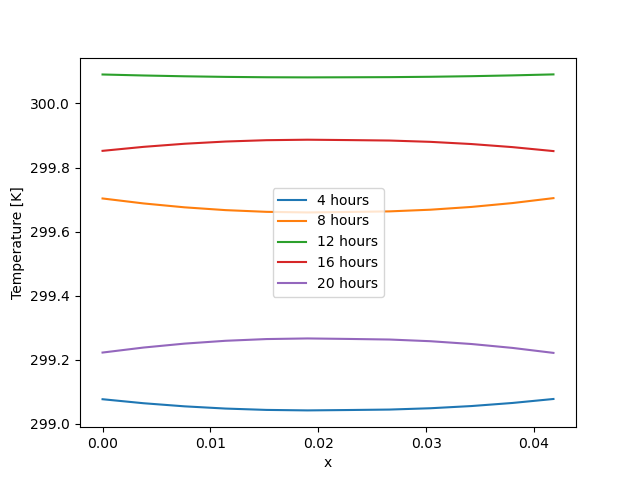

In [221]:
plt.figure()
h_profs = [4, 8, 12, 16, 20]
h_profs = [h + 48 for h in h_profs]
wall = build_sim.bG.G.edges['DR', 'DR']['wall']
T_profs = build_sim.bG.G.edges['DR', 'DR']['T_profs']
for h in h_profs:
    i = int(h * 60 * 60 / build_sim.delt)
    plt.plot(wall.x, T_profs[:, i], label=f'{h % 24} hours')

plt.legend()
plt.xlabel('x')
plt.ylabel('Temperature [K]')
plt.show()

Text(0.5, 1.0, 'Exterior Wall - Floor; Surface Temperatures')

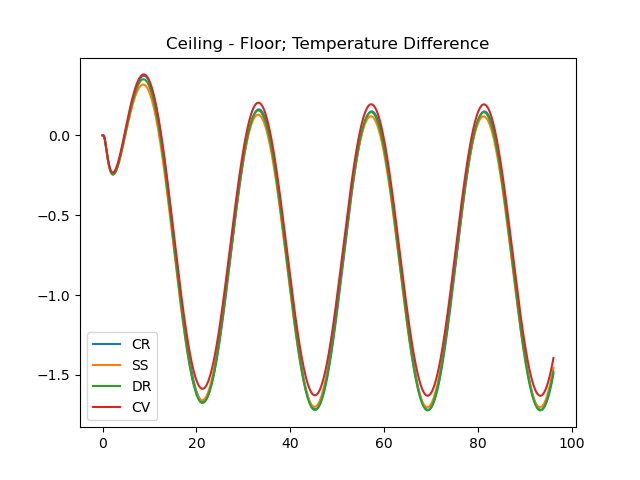

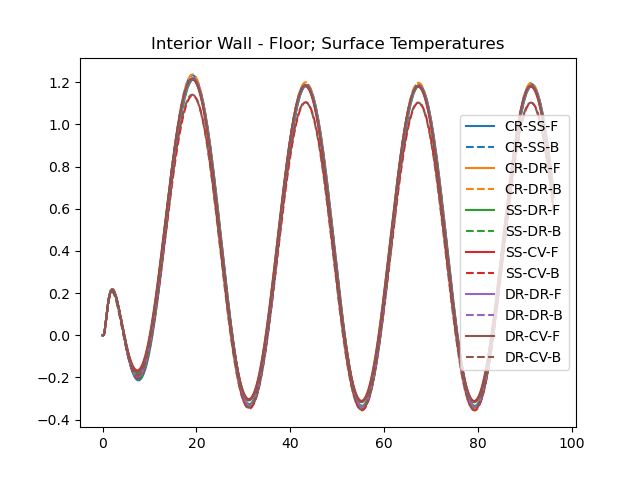

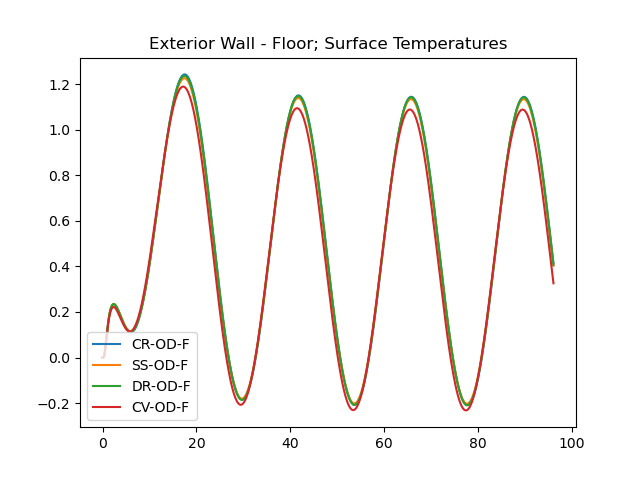

In [222]:
plt.figure()
for n, _ in build_sim.bG.G.nodes(data=True):
    if n in interiorRooms:
        ceiling_temp = build_sim.bG.G[n]["RF"]["T_profs"][0, :]
        floor_temp = build_sim.bG.G[n]["FL"]["T_profs"][0, :]
        plt.plot(build_sim.hours, ceiling_temp - floor_temp, label=n)
plt.legend()
plt.title("Ceiling - Floor; Temperature Difference")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) in interiorRooms and d['nodes'].checkSides(j, False) in interiorRooms:
        colors = list(mcolors.TABLEAU_COLORS.keys())
        linetypes = ['-', '--']
        floor_temp = build_sim.bG.G[i]["RF"]["T_profs"][0, :]
        plt.plot(build_sim.hours, d['T_profs'][0, :] - floor_temp, label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        floor_temp = build_sim.bG.G[j]["RF"]["T_profs"][0, :]
        plt.plot(build_sim.hours, d['T_profs'][-1, :] - floor_temp, label=f'{i}-{j}-B', color = colors[c], linestyle = linetypes[1])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Interior Wall - Floor; Surface Temperatures")

plt.figure()
c = 0
for i, j, d, in build_sim.bG.G.edges(data=True):
    if d['nodes'].checkSides(i, False) == "OD" or d['nodes'].checkSides(j, False) == "OD":
        colors = list(mcolors.TABLEAU_COLORS.keys())
        linetypes = ['-', '--']
        floor_temp = build_sim.bG.G[i]["RF"]["T_profs"][0, :]
        plt.plot(build_sim.hours, d['T_profs'][0, :] - floor_temp, label=f'{i}-{j}-F', color = colors[c], linestyle = linetypes[0])
        c = (c + 1) % len(colors)
plt.legend()
plt.title("Exterior Wall - Floor; Surface Temperatures")

In [223]:
# plt.figure()
# plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radECalc"].front, label='Calculated')
# plt.plot(build_sim.hours, build_sim.bG.G.edges[('RF', 'R')]["radEApplied"].front, label='Applied')
# plt.plot(build_sim.hours, build_sim.bG.G.edges[('FL', 'R')]["radECalc"].front, label='Calculated')
# plt.plot(build_sim.hours, build_sim.bG.G.edges[('FL', 'R')]["radEApplied"].front, label='Applied')
# plt.legend()
# # plt.ylim([-200, 25])
# plt.xlabel('hours')
# plt.ylabel('Radiation [W]')